Title: Basic Video Analysis
Author: Thomas Breuel
Institution: UniKL

# Reading Videos

We use OpenCV for accessing videos. OpenCV is a C++ library for computer vision research. It is very widely used, although the different algorithms in it are of variable quality.



In [2]:
import cv2

OpenCV allows both live video capture and video processing.



In [3]:
video = cv2.VideoCapture()
video.open("videos/testvideo.mp4")
width  = video.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH)
height = video.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT)
nframes = video.get(cv2.cv.CV_CAP_PROP_POS_FRAMES)
print width,height,nframes

True

Frames Iterator:

Let's wrap up the `OpenCV` video function so that it accesses the frames of a video as an iterator.



In [5]:
def frames(fname):
    video = cv2.VideoCapture()
    assert video.open(fname)
    while 1:
        ok,image = video.read()
        if not ok: break
        yield image
    video.release()

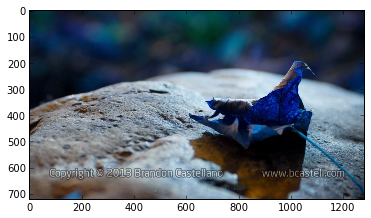

In [6]:
for i,image in enumerate(frames("videos/testvideo.mp4")):
    if i==100: break
imshow(image)

Python Iterators:

Remember the `itertools` package, which gives you powerful and convenient ways of manipulating iterators. For example, `islice` gives you a range of frames from a video when combined with the `frames` iterator.


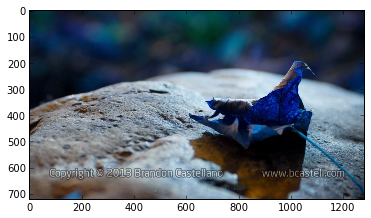

In [7]:
from itertools import islice
imshow(next(islice(frames("videos/testvideo.mp4"),100,101)))

# Fade-to-Black Detection

Videos are usually composed of multiple scenes. Each scene is a continuous sequence of frames, possibly with continuous camera movement. A common scene transition is fade-to-black. It's easy to detect.



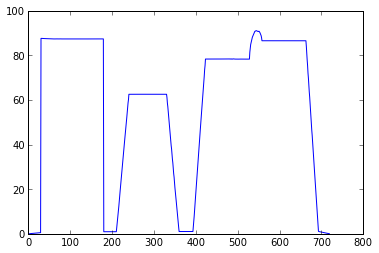

In [8]:
means = [mean(image) for image in frames("videos/testvideo.mp4")]
plot(means)

# Cut Detection

Scene Cut Detection:

Direct cuts are another way in which videos are put together (a softer version of this is dissolves or cross-fades).

These need to be detected as rapid changes in image content. However, for a good job, it's necessary to distinguish cuts from fast motion; we aren't going to discuss that here.

In [75]:

from collections import deque

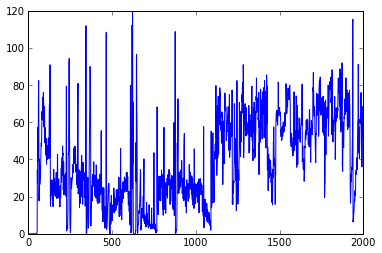

In [9]:
# compute deltas between two frames
deltas = []; nbuf = 3
buffer = deque()
for image in islice(frames("videos/quantum.mp4"),0,2000):
    buffer.append(image)
    while len(buffer)>nbuf: buffer.popleft()
    deltas.append(mean(abs(buffer[-1]-buffer[0])))
deltas = array(deltas); plot(deltas)

compensating for motion:

Motion causes steady deltas in a video, while cuts are very short bursts. To remove motion, we remove a smoothed version of the signal. This is similar to unsharp-mask in image processing.



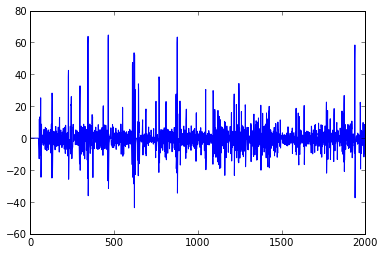

In [10]:
from scipy.ndimage import filters
usm = deltas-filters.gaussian_filter(deltas,2.0)
plot(usm)

global threshold:

Scene cuts in a video should generally have fairly similar magnitudes, so we impose an absolute threshold. We can derive that threshold from the video itself.



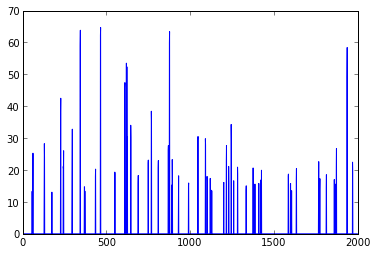

In [11]:
usm = where(usm<0.2*amax(usm),0,usm)
plot(usm)

local threshold:

We also don't want too many cuts within a short period of time. Instead of writing a complicated loop, we can simply use a `maximum_filter`.



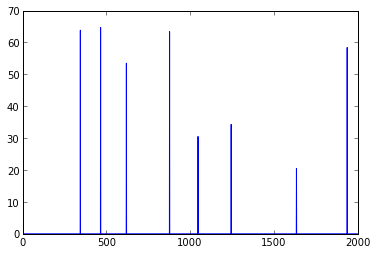

In [12]:
usm = where(usm<filters.maximum_filter(usm,240),0,usm)
plot(usm)

scene cut locations:

We can now identify the scene cut locations as the non-zero values that survive.



In [13]:
find(usm)

array([ 344,  465,  619,  877, 1047, 1245, 1635, 1938])

# Keyframe Detection

In many cases, we want to treat videos like a collection of images. For that, we might select a single shot from the middle of each scene (there are other strategies).



In [14]:
locs = find(usm)
keyindexes = [int(mean([a,b])) for a,b in zip([0]+list(locs),locs)]
print keyindexes

[172, 404, 542, 748, 962, 1146, 1440, 1786]


In [79]:

figsize(12,6)

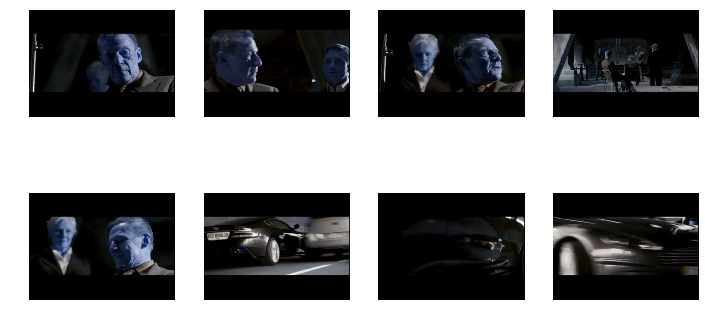

In [80]:
# keyframes
keyframes = []
for i,image in enumerate(frames("videos/quantum.mp4")):
    if i in keyindexes: keyframes.append(image)
for i,image in enumerate(keyframes[:8]):
    subplot(2,4,i+1); axis("off"); imshow(image)

# Shot Clustering

Shot clustering is another strategy for getting a representative collection of frames / images from a video.



In [17]:

figsize(9,6)
from scipy.ndimage import interpolation

We start with regularly spaced samples of video frames.



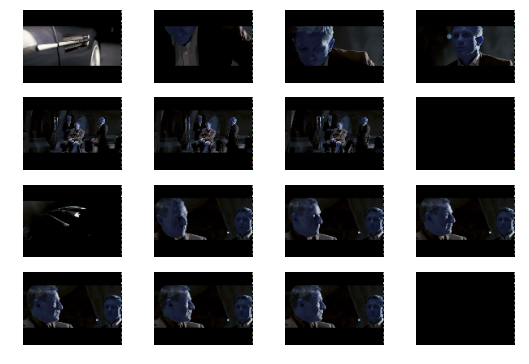

In [64]:
samples = []
for image in islice(frames("videos/quantum.mp4"),0,3000,15):
    samples.append(interpolation.zoom(image,[0.25,0.25,1]))
samples = array(samples,'f')*1.0/amax(samples)
for i,s in enumerate(samples[16:32]):
    subplot(4,4,i+1); axis("off"); imshow(s)

Next, we perform k-means clustering (other kind of clustering algorithms might also work).



In [65]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=25)
data = samples.reshape(len(samples),-1)
km.fit(data)

KMeans(copy_x=True, init='k-means++', k=None, max_iter=300, n_clusters=25,
    n_init=10, n_jobs=1, precompute_distances=True, random_state=None,
    tol=0.0001, verbose=0)

We can now predict, for each frame, which prototype it is most similar to. This can help with scene cut detection, although some additional cleanup is required.



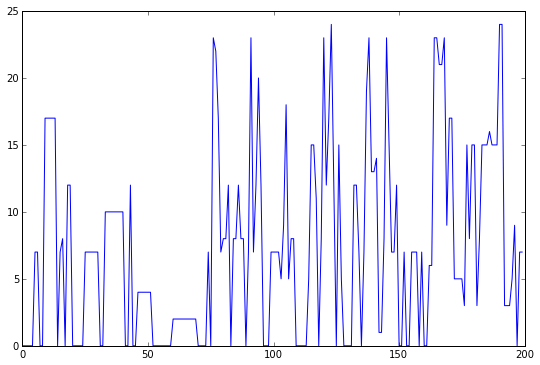

In [70]:
pred = km.predict(data)
plot(pred)

Note that most frames only occur rarely; these should be eliminated.



In [81]:
from collections import Counter
counts = Counter(pred)
counts = [counts[i] for i in range(amax(counts.keys()))]
print sorted(counts)[::-1]
order = argsort(counts)[::-1]

[58, 28, 13, 13, 12, 10, 9, 9, 8, 8, 6, 5, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


The frequently used cluster centers generally represent fairly coarse global illumination patterns, which turns out to be a good choice for scene cut segmentation.



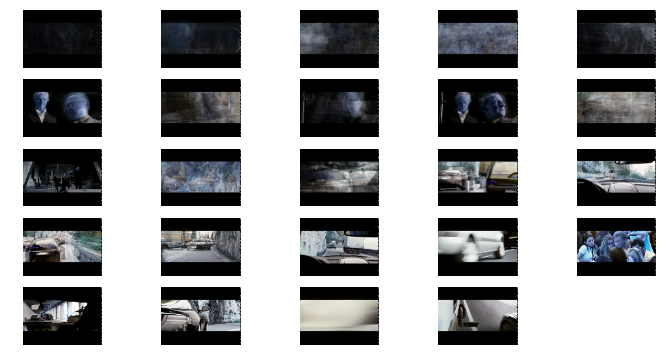

In [83]:
for f,i in enumerate(order):
    c = km.cluster_centers_[i]; subplot(5,5,f+1); axis("off"); imshow(c.reshape(fshape))

# Estimating Motion

In videos, motion is an explicit and very useful feature. We can observe motion in difference frames (here from a car chase scene).



(2, 360, 490)


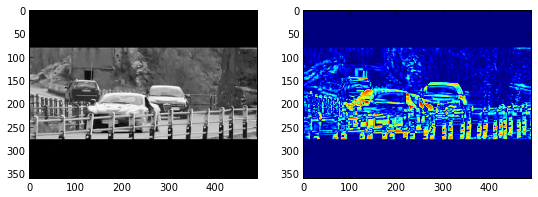

In [48]:
n = 2900
fpair = array(list(islice(frames("videos/quantum.mp4"),n,n+8,4)))/255.0
fpair = mean(fpair,axis=3)
subplot(121); imshow(fpair[0],cmap=cm.gray)
subplot(122); imshow(abs(fpair[1]-fpair[0]))

In [84]:

rows,cols = fpair[0].shape

motion and optical flow:

- many motion and optical flow algorithms
- most detect motion "at the pixel level"
- detecting object motion requires high level knowledge and motion segmentation
- ambiguity - aperture problem
- optical flow algorithms return 2D flow vectors at each point

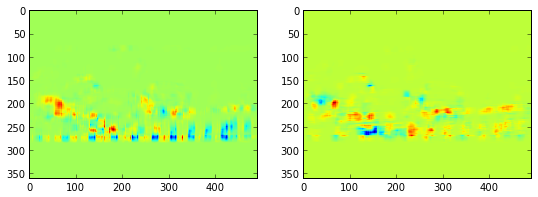

In [73]:
flow = cv2.calcOpticalFlowFarneback(fpair[0],fpair[1],0.5,3,15,3,5,1.2,0)
flow /= amax(abs(flow))
subplot(121); imshow(flow[:,:,0])
subplot(122); imshow(flow[:,:,1])ß

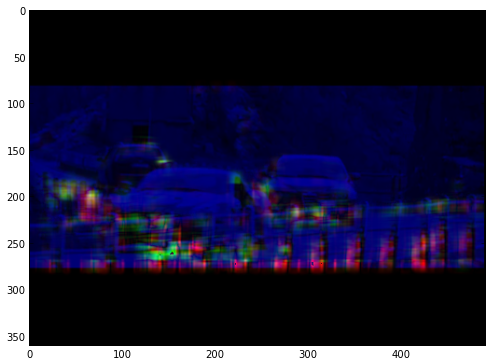

In [85]:
# optical flow overlaid over original image
rgb = transpose(array([flow[:,:,0],flow[:,:,1],0.5*fpair[1]/amax(fpair[1])]),[1,2,0])
imshow(abs(rgb)/amax(rgb))